## Recommender Based on Universal Sentence Encoder

In [1]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import ast

In [2]:
STOP = 100
embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
EMBEDDED_CATEGORIES_FILE = 'data/embedded_categories.npy'
EMBEDDED_ATTRIBUTES_FILE = 'data/embedded_attributes.npy'

In [4]:
def cosine_similarity(mat, vec):
    """
    Calculate cosine similarity scores

    :param mat: 2D array of all targets
    :param vec: 1D array of vector to compare to
    :return: all cosine similarity scores to vec
    """
    vec_mag = np.linalg.norm(vec)
    mat_mag = np.linalg.norm(mat, axis=1).reshape((-1, 1))
    return (1/vec_mag) * np.dot(mat, vec).reshape((-1, 1)) / mat_mag

def return_attribute_soup(input):
    """
    Converts dictionary of inputs into list of items that are true.  Can also handle nested examples

    :param input: dictionary of attributes
    :return: list of keys
    """
    current = []
    for key in input:
        # Inner dictionaries appear to be malformed in places
        try:
            value = ast.literal_eval(input[key])
        except ValueError:
            value = input[key]
        if isinstance(value, dict):
            current.extend(return_attribute_soup(value))
        elif value not in (False, 'No', 'False'):
            current.append(key)
    return current

In [5]:
df_business = pd.read_csv('data/yelp_academic_dataset_business_filtered.csv')
df_business = df_business.dropna(subset=['categories'])
df_business['attributes'] = df_business['attributes'].fillna('{}')

In [6]:
df_business['attribute_dict'] = df_business['attributes'].apply(ast.literal_eval)
df_business['attribute_soup'] = df_business['attribute_dict'].apply(return_attribute_soup)
df_business['attribute_string'] = df_business['attribute_soup'].apply(lambda x: ' '.join(map(str, x)))

In [7]:
try:
    with open(EMBEDDED_CATEGORIES_FILE, 'rb') as f:
        embedded_categories = np.load(EMBEDDED_CATEGORIES_FILE, allow_pickle=True)

    with open(EMBEDDED_ATTRIBUTES_FILE, 'rb') as f:
        embedded_attributes = np.load(EMBEDDED_ATTRIBUTES_FILE, allow_pickle=True)

    print('EMBEDDINGS LOADED')

except IOError as e:
    print('ARRAY(S) NOT FOUND. EMBEDDING:')
    categories = list(df_business['categories'])
    embedded_categories = embedder(categories).numpy()
    np.save(EMBEDDED_CATEGORIES_FILE, embedded_categories)

    attributes = list(df_business['attribute_string'])
    embedded_attributes = embedder(attributes).numpy()
    np.save(EMBEDDED_ATTRIBUTES_FILE, embedded_attributes)
    print('EMBEDDINGS SAVED')


ARRAY(S) NOT FOUND. EMBEDDING:
EMBEDDINGS SAVED


In [8]:
def get_knn(input, embedded_attributes, embedded_categories, df_business, k=5, category_weighting=0.75, min_rating=-1, verbose=False):
    """
    Get the most similar businesses by knn search and sort.  This function assumes recommendations are in the same state
    and that the restaurants are rated greater than or equal to 4 stars.

    :param input: input business, in the form of a Series
    :param embedded_attributes: services offered at the business
    :param embedded_categories: embedded categories (business type)
    :param df_business: DataFrame of all business info that must match embedded_attributes
    :param k: Number of top results desired
    :param category_weighting: emphasis placed on the contents of the restaurant.
    :return: DataFrame of similar businesses
    """
    assert df_business.shape[0] == embedded_categories.shape[0]
    assert df_business.shape[0] == embedded_attributes.shape[0]

    # Filter by state before continuing
    df_business_copy = df_business.copy()
    state = input['state']
    city = input['city']
    query_id = input['business_id']
    # List of all matching indices
    match_dex = df_business.index[(df_business['city'] == city) & (df_business['state'] == state) & (df_business['stars'] >= 4)].tolist()

    embedded_attributes = embedded_attributes[match_dex]
    embedded_categories = embedded_categories[match_dex]
    df_business_copy = df_business.loc[match_dex, :]


    query_category = input.loc['categories']
    query_attributes = input.loc['attribute_string']
    if verbose: print("INPUT BUSINESS:", input.loc['name'])
    embedded_query_category = embedder([query_category]).numpy().flatten()
    embedded_query_attributes = embedder([query_attributes]).numpy().flatten()

    categ_simil_scores = cosine_similarity(embedded_categories, embedded_query_category).flatten()
    attri_simil_scores = cosine_similarity(embedded_attributes, embedded_query_attributes).flatten()

    weighted_simil_scores = category_weighting * categ_simil_scores + (1 - category_weighting) + attri_simil_scores
    weighted_simil_scores *= 0.5

    df_business_copy['scores'] = weighted_simil_scores

    # After filtering, choose the smallest, account for perfect match
    available_businesses = weighted_simil_scores.shape[0]
    k = min(k + 1, available_businesses)

    indices = np.argsort(weighted_simil_scores)[-k:][::-1]
    ret = df_business_copy.iloc[indices, :]
    return ret[(ret['stars'] >= min_rating) & (ret['business_id'] != query_id)]

In [9]:
df_business.head()

,Unnamed: 0,Unnamed: 0.1,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,attribute_dict,attribute_soup,attribute_string
0,0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","{'RestaurantsTableService': 'True', 'WiFi': 'u...","[RestaurantsTableService, WiFi, BikeParking, s...",RestaurantsTableService WiFi BikeParking stree...
1,1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...","{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","[RestaurantsTakeOut, RestaurantsAttire, GoodFo...",RestaurantsTakeOut RestaurantsAttire GoodForKi...
2,5,5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': ""u'none'"", ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...","{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","[GoodForKids, Alcohol, RestaurantsGoodForGroup...",GoodForKids Alcohol RestaurantsGoodForGroups R...
3,10,10,rYs_1pNB_RMtn5WQh55QDA,Chautauqua General Store,100 Clematis Dr,Boulder,CO,80302,39.998449,-105.281006,3.5,5,1,"{'BikeParking': 'True', 'RestaurantsTakeOut': ...","Food, Shopping, Convenience Stores, Souvenir S...","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...","{'BikeParking': 'True', 'RestaurantsTakeOut': ...","[BikeParking, RestaurantsTakeOut, street, Whee...",BikeParking RestaurantsTakeOut street Wheelcha...
4,12,12,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,1,"{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","Food, Pizza, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","{'RestaurantsGoodForGroups': 'True', 'HasTV': ...","[RestaurantsGoodForGroups, HasTV, GoodForKids,...",RestaurantsGoodForGroups HasTV GoodForKids Res...


In [10]:
%%time
results = get_knn(df_business.iloc[0, :], embedded_attributes, embedded_categories, df_business, category_weighting=0.5)
results.head()

CPU times: user 85.2 ms, sys: 45.7 ms, total: 131 ms
Wall time: 99 ms


,Unnamed: 0,Unnamed: 0.1,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,attribute_dict,attribute_soup,attribute_string,scores
19374,59580,59580,GDmUoW3hmokCMAVys8M1PQ,The Post Brewing Co. Boulder,2027 13th St,Boulder,CO,80302,40.018848,-105.279096,4.0,179,1,"{'BikeParking': 'True', 'HappyHour': 'True', '...","Pubs, Breweries, Chicken Shop, American (Tradi...","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...","{'BikeParking': 'True', 'HappyHour': 'True', '...","[BikeParking, HappyHour, HasTV, casual, Alcoho...",BikeParking HappyHour HasTV casual Alcohol Whe...,0.856014
38669,118221,118221,_GteKUXq5Hx0ZTzzAkUW9g,Twisted Pine Brewing Company,3201 Walnut St,Boulder,CO,80301,40.020832,-105.251023,4.0,306,1,"{'HasTV': 'True', 'BusinessParking': ""{'garage...","Sports Bars, Sandwiches, Pubs, Food, Breweries...","{'Monday': '0:0-0:0', 'Friday': '16:0-19:0', '...","{'HasTV': 'True', 'BusinessParking': '{'garage...","[HasTV, street, lot, BikeParking, RestaurantsG...",HasTV street lot BikeParking RestaurantsGoodFo...,0.852223
5130,15784,15784,rrXppQgpsjFZs8TCRNcfhg,Upslope Brewing Company - Flatiron Park,1898 S Flatiron Ct,Boulder,CO,80301,40.020163,-105.218338,4.5,84,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Beer, Wine & Spirits, Breweries, Bars, Nightli...","{'Monday': '12:0-20:0', 'Tuesday': '12:0-20:0'...","{'BikeParking': 'True', 'RestaurantsPriceRange...","[BikeParking, RestaurantsPriceRange2, Business...",BikeParking RestaurantsPriceRange2 BusinessAcc...,0.839652
48625,148328,148328,SXgLnNoWd62TEiqBYRiIkA,Peckish,1320 College Ave,Boulder,CO,80302,40.007179,-105.275761,4.0,20,1,"{'BYOB': 'False', 'Ambience': ""{'touristy': Fa...","Bars, Beer Bar, Sports Bars, Sandwiches, Chick...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...","{'BYOB': 'False', 'Ambience': '{'touristy': Fa...","[RestaurantsTakeOut, street, WiFi, HasTV, Alco...",RestaurantsTakeOut street WiFi HasTV Alcohol W...,0.814933
30640,93970,93970,-XHAfXRTrhQ2_kimhpMczA,The Barrel - Boulder,"1710 29th St, Ste 1048, Twenty Ninth Street Ce...",Boulder,CO,80301,40.017805,-105.255229,4.0,13,0,"{'HasTV': 'True', 'Music': ""{'dj': False, 'bac...","Beer, Wine & Spirits, Nightlife, Beer Gardens,...","{'Monday': '0:0-0:0', 'Friday': '15:0-21:0', '...","{'HasTV': 'True', 'Music': '{'dj': False, 'bac...","[HasTV, BusinessAcceptsCreditCards, DogsAllowe...",HasTV BusinessAcceptsCreditCards DogsAllowed R...,0.810398


### Load the users and their reviews into a train and testable form
Given a user:
- Find all reviews produced by this user
- Filter to only positive reviews (4 stars or above)
- For each positive review, find the top 5 most similar restaurants in the area specified by the review (it's unlikely the user would be willing to travel across the country to find a restaurant that might just be similar)
- Pool all of the results, and sort by similarity scores.  Therefore, the user should have a collection of potential places to visit.

By using a text embedder to calculate similarity, a training set isn't truly needed:
- Require at least 2 good reviews from each test user, otherwise skip the training instance although a larger threshold for minimum number of reviews may make more sense.
- For each user, having $$n$$ reviews, we randomly use 50% of the reviews for generating similar results.  Then, follow the above results to obtain $5n/2$ predictions.
- We examine whether the predictions and remaining $n/2$ test reviews have _any_ intersection (although we can change this later).


In [11]:
%%time
df_users = pd.read_csv('data/yelp_academic_dataset_user.csv')
df_reviews = pd.read_csv('data/yelp_academic_dataset_review.csv')
print("REVIEWS SIZE:", df_reviews.shape[0])
print("USERS SIZE:", df_users.shape[0])

REVIEWS SIZE: 8635403
USERS SIZE: 2189457
CPU times: user 1min 41s, sys: 32.4 s, total: 2min 13s
Wall time: 2min 27s


In [12]:
# Set of restaurant IDs
restaurant_set = set(df_business['business_id'].values)
# Only keep restaurant reviews in the filtered dataset
df_reviews_final = df_reviews[df_reviews['business_id'].isin(restaurant_set)]
# Remove bad reviews
df_reviews_final = df_reviews_final[df_reviews_final['stars'] >= 4]

In [13]:
df_reviews_sampled = df_reviews_final.sample(n=1_000_000, replace=False)

In [14]:
user_id_set = set(df_reviews_sampled['user_id'].values)
df_users_sampled = df_users[df_users['user_id'].isin(user_id_set)]

In [15]:
df_user_and_review = pd.merge(df_reviews_sampled, df_users_sampled, on='user_id')

In [25]:
df_all_filtered = df_user_and_review[df_user_and_review.groupby('user_id').transform('count')['review_id'] > 6]

In [24]:
user_id_set = set(df_all_filtered['user_id'].values)
print("SATISFYING USERS:", len(user_id_set))

SATISFYING USERS: 18846


In [19]:
def get_all_user_recommendations(df_individual_reviews, df_business, embedded_attributes, embedded_categories):
    """
    Gets a DataFrame of all recommendations.  If the user reviews n items positively, return 5n items that they might enjoy.
    :param user_id: id of the queried user
    :param df_individual_reviews: reviews from a given user.
    :param df_business: DataFrame including all potential businesses
    :return: DataFrame of all recommendations
    """
    all_rec = []
    for business_id in df_individual_reviews['business_id']:
        # Retrieve first instance
        df_input_business = df_business[df_business['business_id'] == business_id].iloc[0, :]
        # Append all corresponding predictions
        all_rec.append(get_knn(df_input_business, embedded_attributes, embedded_categories, df_business, category_weighting=0.5))
    return pd.concat(all_rec)

In [20]:
# Single User Demo:

user_iter = iter(user_id_set)
user_id = next(user_iter)

data = df_all_filtered[df_all_filtered['user_id'] == user_id]
y_pred = get_all_user_recommendations(data, df_business, embedded_attributes, embedded_categories)
y_pred


,Unnamed: 0,Unnamed: 0.1,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,attribute_dict,attribute_soup,attribute_string,scores
43030,131531,131531,DmtPWnRPEvnwVmMlvcahzA,16C,16 Cottage Ave,Quincy,MA,01069,42.248348,-71.001546,4.0,198,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, American (Traditional), Pizza, Sa...","{'Tuesday': '17:0-22:0', 'Wednesday': '17:0-22...","{'BusinessAcceptsCreditCards': 'True', 'Restau...","[BusinessAcceptsCreditCards, GoodForKids, Rest...",BusinessAcceptsCreditCards GoodForKids Restaur...,0.851364
16933,52094,52094,xkLwAfgIYXYHzJF8C_fhCA,Tony's Clam Shop,861 Quincy Shore Dr,Quincy,MA,02170,42.275224,-71.005992,4.0,582,1,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Fast Food, Seafood, Sandwiches, Wraps, Restaur...","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...","{'RestaurantsAttire': ''casual'', 'BusinessAcc...","[RestaurantsAttire, BusinessAcceptsCreditCards...",RestaurantsAttire BusinessAcceptsCreditCards R...,0.812398
15074,46421,46421,rlnEm-mJWGR0q807Ei_NHw,The Chantey At Marina Bay,333 Victory Rd,Quincy,MA,02171,42.299480,-71.027952,4.0,55,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Pizza, Nightlife, Bars, Restaurants, American ...","{'Monday': '11:30-21:30', 'Tuesday': '11:30-21...","{'RestaurantsReservations': 'False', 'GoodForK...","[GoodForKids, Alcohol, HasTV, OutdoorSeating, ...",GoodForKids Alcohol HasTV OutdoorSeating Resta...,0.808186
20926,64422,64422,Xg7pVJHfpqO2Zm742Qk7Xw,Bravo Pizzeria,531 Washington St,Quincy,MA,02169,42.247269,-70.979850,4.5,138,1,"{'Caters': 'True', 'BikeParking': 'True', 'Res...","Pizza, Restaurants, Salad, Ice Cream & Frozen ...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","{'Caters': 'True', 'BikeParking': 'True', 'Res...","[Caters, BikeParking, RestaurantsAttire, HasTV...",Caters BikeParking RestaurantsAttire HasTV Res...,0.806860
16938,52110,52110,4lXOZikoMRUxC24ViFnzeQ,Fish n Chicken,110 Willard St,Quincy,MA,02169,42.251631,-71.036266,4.0,60,1,"{'Caters': 'True', 'BikeParking': 'True', 'Res...","Restaurants, American (Traditional)","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...","{'Caters': 'True', 'BikeParking': 'True', 'Res...","[Caters, BikeParking, RestaurantsTakeOut, Alco...",Caters BikeParking RestaurantsTakeOut Alcohol ...,0.794355
9843,30372,30372,s_dEdgoBhxfQaroUcVu1aQ,I Love Italian Pizza,68 Newbury Ave,Quincy,MA,02171,42.281397,-71.029023,4.0,132,1,"{'RestaurantsAttire': ""u'casual'"", 'Alcohol': ...","Pizza, Restaurants, Food, Italian","{'Monday': '0:0-0:0', 'Tuesday': '10:0-22:0', ...","{'RestaurantsAttire': 'u'casual'', 'Alcohol': ...","[RestaurantsAttire, Alcohol, RestaurantsPriceR...",RestaurantsAttire Alcohol RestaurantsPriceRang...,0.775068
28466,87338,87338,sueo3UfT1ZZirX69-s7POw,McKay's Breakfast and Lunch,144 Franklin St,Quincy,MA,02169,42.238816,-71.003113,4.0,179,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, American (Traditional), Breakfast...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ...","{'GoodForKids': 'True', 'RestaurantsDelivery':...","[GoodForKids, RestaurantsPriceRange2, Restaura...",GoodForKids RestaurantsPriceRange2 Restaurants...,0.901917
43347,132443,132443,y9PNBfvc8ad9KJlWkoQUZQ,Granite Street Cafe,378 Granite St,Quincy,MA,02169,42.242191,-71.015000,4.0,160,1,"{'RestaurantsAttire': ""u'casual'"", 'HasTV': 'T...","American (Traditional), Italian, Restaurants, ...","{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...","{'RestaurantsAttire': 'u'casual'', 'HasTV': 'T...","[RestaurantsAttire, HasTV, RestaurantsReservat...",RestaurantsAttire HasTV RestaurantsReservation...,0.863317
77,221,221,fD9EopsUWvimsi4eaS7uMA,The Wheelhouse Diner,453 Hancock St,Quincy,MA,02171,42.272234,-71.023950,4.0,229,1,"{'HasTV': 'False', 'BusinessParking': ""{'garag...","Diners, Restaurants","{'Wednesday': '5:0-15:0', 'Thursday': '5:0-11:...","{'HasTV': 'False', 'BusinessParking': '{'garag

In [26]:
# Test Loop Imports
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [27]:
# TEST LOOP
user_iter = iter(user_id_set)
hit = 0

EXAMPLES = 100

for dex in tqdm(range(EXAMPLES)):
    user_id = next(user_iter)
    data = df_all_filtered[df_all_filtered['user_id'] == user_id]
    X, y = train_test_split(data, train_size=0.5)
    y_pred = get_all_user_recommendations(X, df_business, embedded_attributes, embedded_categories)

    y_businesses = set(y['business_id'].values)
    y_pred_businesses = set(y_pred['business_id'].values)
    if len(y_pred_businesses.intersection(y_businesses)) > 0:
        hit += 1

print(hit/EXAMPLES)

  0%|          | 0/100 [00:00<?, ?it/s]

0.15


In [ ]:
EXAMPLES = 1000

for dex in tqdm(range(EXAMPLES)):
    user_id = next(user_iter)
    data = df_all_filtered[df_all_filtered['user_id'] == user_id]
    X, y = train_test_split(data, train_size=0.5)
    y_pred = get_all_user_recommendations(X, df_business, embedded_attributes, embedded_categories)

    y_businesses = set(y['business_id'].values)
    y_pred_businesses = set(y_pred['business_id'].values)
    if len(y_pred_businesses.intersection(y_businesses)) > 0:
        hit += 1

print(hit/EXAMPLES)

## Minimum Number of Reviews Threshold

In [35]:
%%time
min_thresholds = [2, 4, 6, 8, 10, 12]

for threshold in min_thresholds:
    df_all_filtered = df_user_and_review[df_user_and_review.groupby('user_id').transform('count')['review_id'] > threshold]
    user_id_set = set(df_all_filtered['user_id'].values)
    user_iter = iter(user_id_set)
    hit = 0
    EXAMPLES = 500

    for dex in tqdm(range(EXAMPLES)):
        user_id = next(user_iter)
        data = df_all_filtered[df_all_filtered['user_id'] == user_id]
        X, y = train_test_split(data, train_size=0.5)
        y_pred = get_all_user_recommendations(X, df_business, embedded_attributes, embedded_categories)

        y_businesses = set(y['business_id'].values)
        y_pred_businesses = set(y_pred['business_id'].values)
        if len(y_pred_businesses.intersection(y_businesses)) > 0:
            hit += 1

    print("Threshold: ", threshold, "Accuracy", hit/EXAMPLES)

  0%|          | 0/500 [00:00<?, ?it/s]

Threshold:  2 Accuracy 0.078
Threshold:  4 Accuracy 0.15
Threshold:  6 Accuracy 0.24
Threshold:  8 Accuracy 0.268
Threshold:  10 Accuracy 0.346
Threshold:  12 Accuracy 0.43
CPU times: user 1h 17min 49s, sys: 19min 37s, total: 1h 37min 26s
Wall time: 17min 2s


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Sample Prediction

In [67]:
df_all_filtered = df_user_and_review[df_user_and_review.groupby('user_id').transform('count')['review_id'] == 3]
user_id_set = list(df_all_filtered['user_id'].values)
user_id = user_id_set[0]
data = df_all_filtered[df_all_filtered['user_id'] == user_id]
y_pred = get_all_user_recommendations(data, df_business, embedded_attributes, embedded_categories)

In [74]:
out_pred = pd.merge(df_business, y_pred, on='business_id')
out_pred = out_pred[['name_x', 'city_x', 'state_x', 'attribute_string_y', 'categories_y', 'scores']].sort_values(by='scores', ascending=False)

In [75]:
out_in = pd.merge(df_business, data, on='business_id')
out_in = out_in[['name_x', 'city', 'state', 'attribute_string', 'categories']]
#out_in[['name_x', 'city_x', 'state_x', 'attribute_string_y', 'categories_y']]

In [100]:
import dataframe_image as dfi

dfi.export(out_pred.head(15).reset_index(drop=True), 'data/business_predictions.png')
dfi.export(out_in, 'data/positive_user.png')

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

data_performance = {'minimum review count':[2, 4, 6, 8, 10, 12],
                    'hit proportion':[0.078, 0.15, 0.24, 0.268, 0.346, 0.43]}
data_speed = {'minimum review count':[2, 4, 6, 8, 10, 12],
              'testing time (s)':[99, 121, 145, 172, 197, 259]}

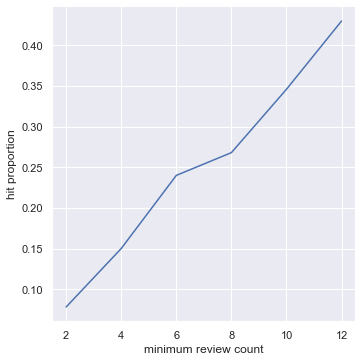

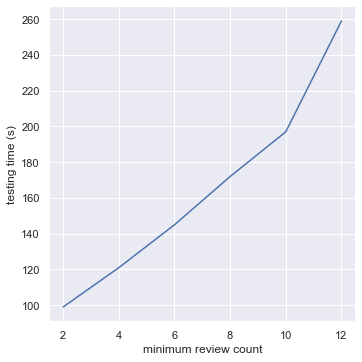

In [95]:
sns.set_theme()
sns_plot = sns.relplot(data=data_performance, x='minimum review count', y='hit proportion', kind='line')
sns_plot.savefig('data/performance.png')
plt.show()

sns_plot = sns.relplot(data=data_speed, x='minimum review count', y='testing time (s)', kind='line')
sns_plot.savefig('data/speed.png')
plt.show()

In [94]:
performance = pd.DataFrame(data_performance)
dfi.export(performance, 'data/performance_table.png')